In [21]:
import os, sys
from pathlib import Path

sys.path.insert(0, os.getcwd())

import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import h5py

from notebook.util import (
    fetch_to_cache, list_2d_datasets, plot_raster, print_stats,
    robust_percentiles
)



# 1. Download NISAR GCOV 

DSWx-NI is intended to run on NISAR L2 GCOV inputs. Since operational NISAR data are not yet available, this notebook substitutes a simulated NISAR GCOV product. The workflow is identical—simply replace the simulated file with a real GCOV when it becomes available.

In [22]:

url = "https://github.com/opera-adt/DSWX-SAR/releases/download/uavsar_gcov_sample/pad_uavsar.zip"
local_path = fetch_to_cache(url, cache_dir="./_cache")
print("Saved to:", local_path)

import zipfile, pathlib
extract_dir = pathlib.Path("./_cache/pad_uavsar")
extract_dir.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(local_path, "r") as z:
    z.extractall(extract_dir)
print("Extracted to:", extract_dir)

Saved to: _cache/pad_uavsar.zip
Extracted to: _cache/pad_uavsar


# 2. GCOV and Ancillary data

### 2.1 ) Core radar input (GCOV)

#### Recommended: Dual-pol: HH/HV or VV/VH.

   * Identifies co-pol (HH or VV) and cross-pol (HV or VH).
   - Enables inundated vegetation detection (important in forests).

#### Supported: Single-pol, but inundated-vegetation logic is limited/disabled.

Data root: /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/pad_uavsar
Found 5 GeoTIFF(s) and 2 GCOV/HDF5 file(s).

--- GCOV preview: gcov.h5 ---
2D datasets (first 12):
   science/LSAR/GCOV/grids/frequencyA/HHHH
   science/LSAR/GCOV/grids/frequencyA/HVHV
   science/LSAR/GCOV/grids/frequencyA/VHVH
   science/LSAR/GCOV/grids/frequencyA/VVVV
   science/LSAR/GCOV/grids/frequencyA/mask
   science/LSAR/GCOV/grids/frequencyA/numberOfLooks
   science/LSAR/GCOV/grids/frequencyA/rtcGammaToSigmaFactor
   science/LSAR/GCOV/metadata/attitude/eulerAngles
   science/LSAR/GCOV/metadata/attitude/quaternions
   science/LSAR/GCOV/metadata/calibrationInformation/frequencyA/elevationAntennaPattern/HH
   science/LSAR/GCOV/metadata/calibrationInformation/frequencyA/elevationAntennaPattern/HV
   science/LSAR/GCOV/metadata/calibrationInformation/frequencyA/elevationAntennaPattern/VH

Visualizing: ['science/LSAR/GCOV/grids/frequencyA/HHHH', 'science/LSAR/GCOV/grids/frequencyA/HVHV', 'science

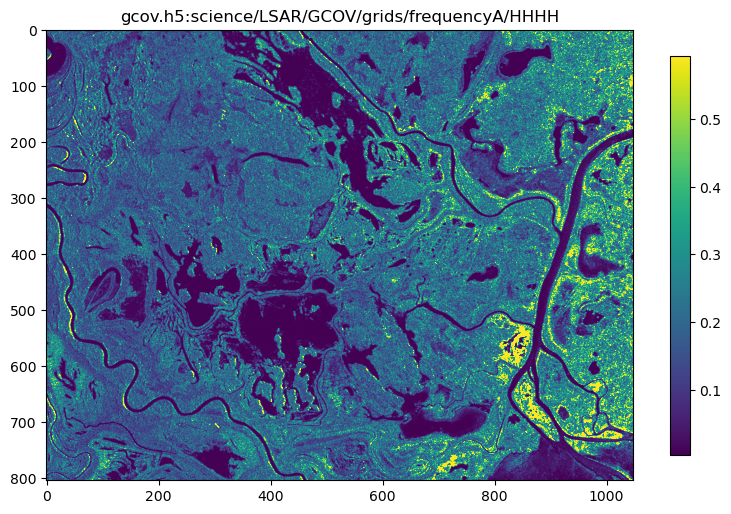

science/LSAR/GCOV/grids/frequencyA/HHHH: min=0.0005  p2=0.0041  med=0.1646  p98=0.5936  max=4.9614  n=842592


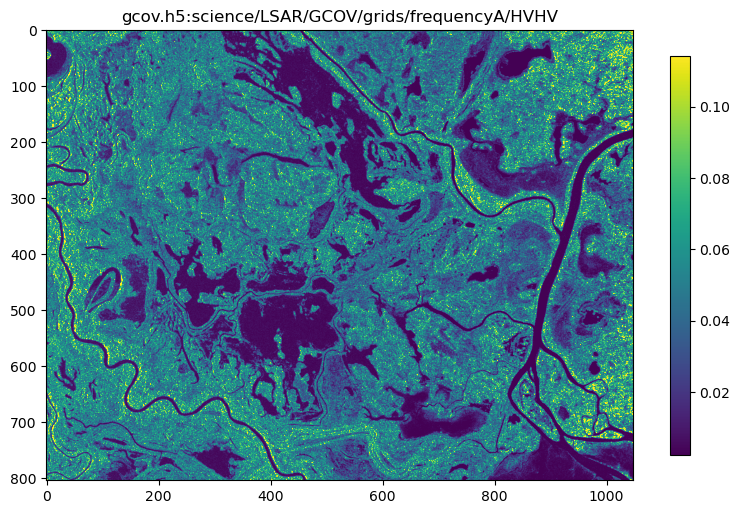

science/LSAR/GCOV/grids/frequencyA/HVHV: min=0.0004  p2=0.0024  med=0.0394  p98=0.1143  max=0.5146  n=842592


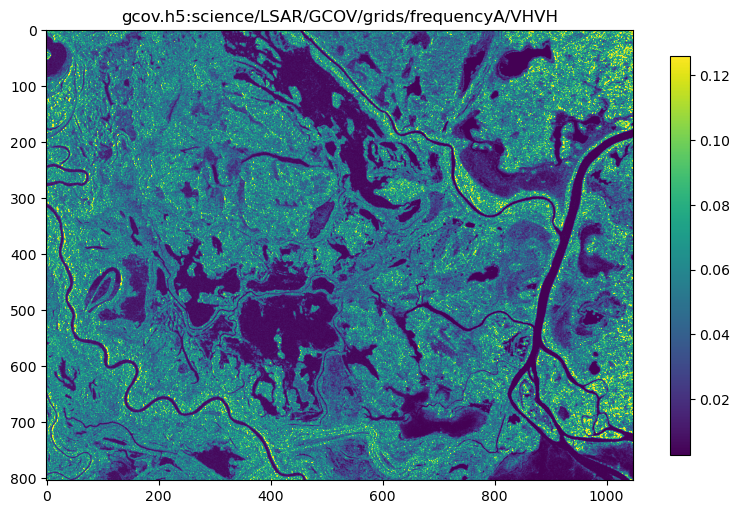

science/LSAR/GCOV/grids/frequencyA/VHVH: min=0.0004  p2=0.0028  med=0.0436  p98=0.1261  max=0.4180  n=842592


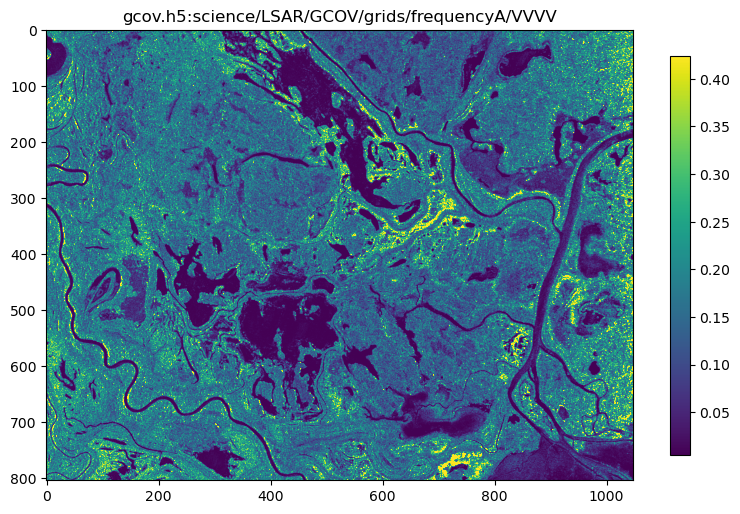

science/LSAR/GCOV/grids/frequencyA/VVVV: min=0.0005  p2=0.0055  med=0.1326  p98=0.4243  max=4.2936  n=842592


In [23]:

DATA_ROOT = Path("./_cache/pad_uavsar").resolve()

tif_paths  = sorted([p for p in DATA_ROOT.rglob("*.tif*") if p.is_file()])
h5_paths   = sorted([p for p in DATA_ROOT.rglob("*gcov*.h5*")] +
                    [p for p in DATA_ROOT.rglob("*.h5")])

print(f"Data root: {DATA_ROOT}")
print(f"Found {len(tif_paths)} GeoTIFF(s) and {len(h5_paths)} GCOV/HDF5 file(s).")


for gpath in h5_paths[:1]:  # show first GCOV file
    print(f"\n--- GCOV preview: {gpath.name} ---")
    with h5py.File(gpath, "r") as h:
        names = list_2d_datasets(h)
        print("2D datasets (first 12):")
        for n in names[:12]:
            print("  ", n)
        # choose up to 4 by priority, then fill with first remaining
        picked = []
        for n in names:
            if n not in picked: picked.append(n)
        picked = picked[:4] if picked else names[:4]

        print("\nVisualizing:", picked)
        for n in picked:
            d = h[n][...].astype("float64")
            plot_raster(d, f"{gpath.name}:{n}")
            print_stats(d, n)


### 2.2 ) Ancillary data

DEM (e.g., Copernicus, void-filled): topographic masking/corrections.

Land cover (e.g., ESA WorldCover, GLAD): masks & decision logic.

Reference water (e.g., JRC Global Surface Water occurrence): separates persistent water.

HAND (Height Above Nearest Drainage): floodplain likelihood.

Shoreline (optional, vector): coastal masking.

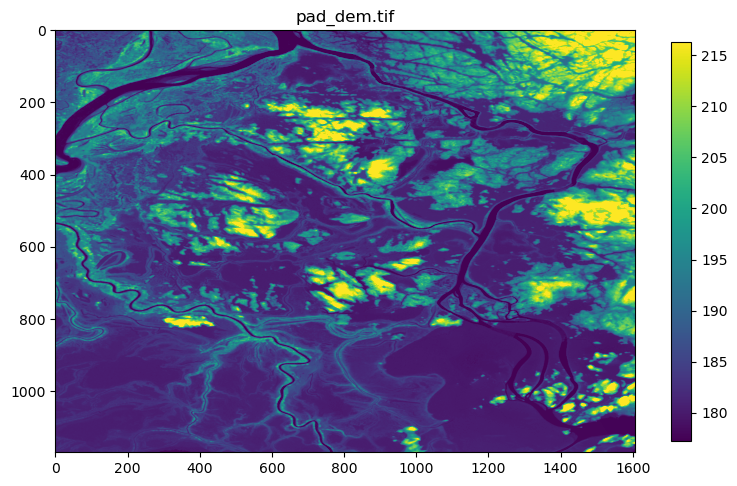

pad_dem.tif: min=171.6826  p2=177.2604  med=183.7934  p98=216.3221  max=251.5945  n=1880190


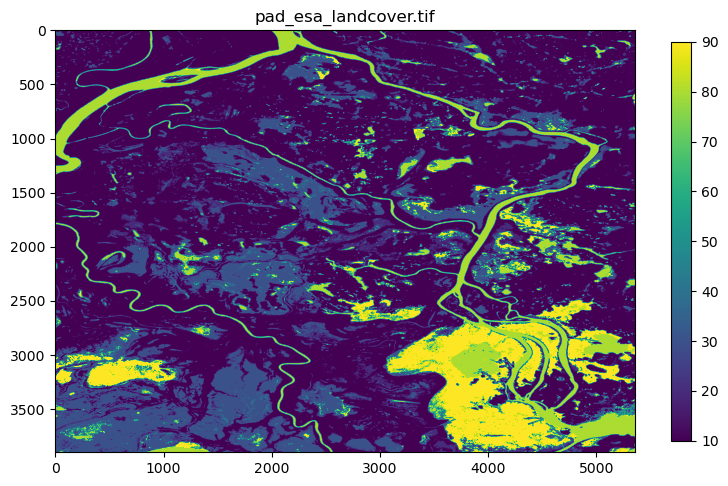

pad_esa_landcover.tif: min=10.0000  p2=10.0000  med=10.0000  p98=90.0000  max=100.0000  n=20886943


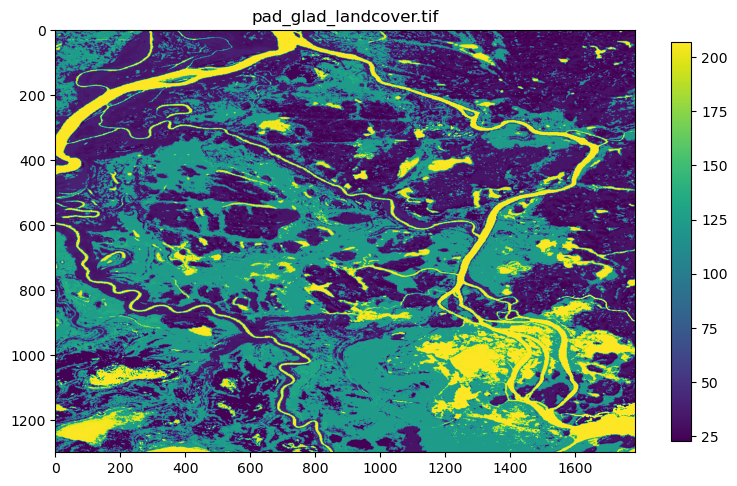

pad_glad_landcover.tif: min=0.0000  p2=23.0000  med=122.0000  p98=207.0000  max=254.0000  n=2321800


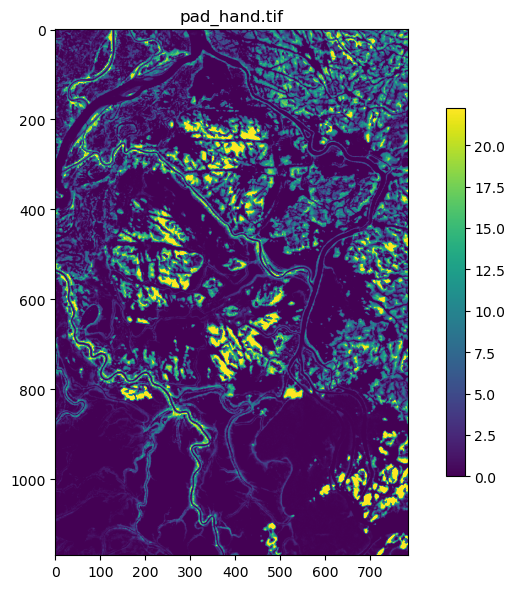

pad_hand.tif: min=0.0000  p2=0.0000  med=0.2271  p98=22.2332  max=65.3997  n=917280


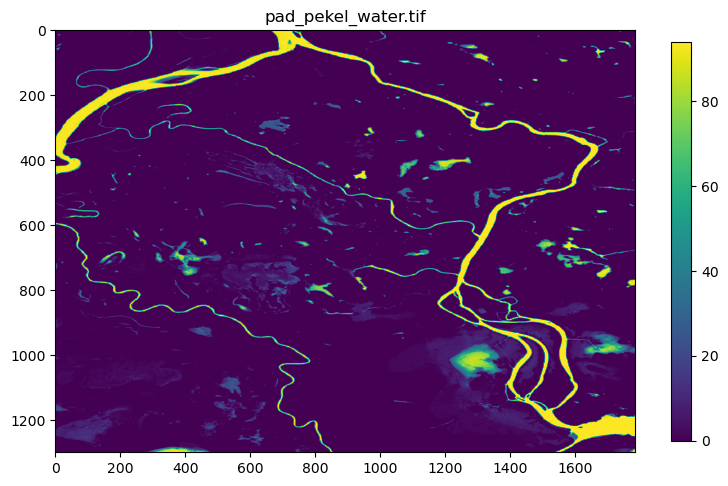

pad_pekel_water.tif: min=0.0000  p2=0.0000  med=0.0000  p98=94.0000  max=99.0000  n=2321800


In [24]:

for tif in tif_paths:
    try:
        with rio.open(tif) as src:
            title = tif.name
            if src.count >= 3:
                # quick RGB from first 3 bands with simple per-band stretch
                rgb = np.stack([src.read(1), src.read(2), src.read(3)], axis=-1).astype("float64")
                for i in range(3):
                    vmin, vmax = robust_percentiles(rgb[..., i])
                    if vmax > vmin:
                        rgb[..., i] = np.clip((rgb[..., i] - vmin) / (vmax - vmin + 1e-12), 0, 1)
                plt.figure(figsize=(8,6))
                plt.imshow(rgb)
                plt.title(f"{title} (RGB 1/2/3)")
                plt.tight_layout(); plt.show()
            else:
                arr = src.read(1).astype("float64")
                plot_raster(arr, title)
                print_stats(arr, title)
    except Exception as e:
        print(f"[WARN] {tif.name}: {e}")


# 3. Build yaml files

This workflow is configured via a runconfig YAML, which sets both inputs and outputs.

In [25]:
sys.path.insert(0, f"{os.getcwd()}/src")
from dswx_sar.dswx_ni import dswx_ni_workflow


In [26]:
BASE = "."
def _abs(p):
    if p is None:
        return None
    p = Path(p)
    if p.is_absolute():
        return str(p)
    return str((Path(BASE) / p).resolve())

import yaml
from pathlib import Path

yaml_out = Path("./_cache/runconfig.yaml")        # where to save the wrapper runconfig

input_file_paths = [
    _abs("_cache/pad_uavsar/gcov.h5"), 
]

dynamic = {
    "dem_file": "_cache/pad_uavsar/pad_dem.tif",
    "worldcover_file": "_cache/pad_uavsar/pad_esa_landcover.tif",
    "glad_classification_file": "_cache/pad_uavsar/pad_glad_landcover.tif",
    "reference_water_file": "_cache/pad_uavsar/pad_pekel_water.tif",
    "hand_file": "_cache/pad_uavsar/pad_hand.tif",
    "algorithm_parameters": _abs("src/dswx_sar/defaults/algorithm_parameter_ni.yaml"),
}

static = {
    "static_ancillary_inputs_flag": False,
}

product_paths = {
    "product_path":  _abs("_cache/products"),
    "scratch_path":     _abs("_cache/scratch"),
    "sas_output_path":  _abs("_cache/products"),
    "product_version":  0.3,    # keep as string to be safe
    "output_imagery_format": "COG",
    "output_imagery_compression": "DEFLATE",
    "output_imagery_nbits": 32,
}

browse = {
      "save_browse": True,
      "browse_image_height": 1024,
      "browse_image_width": 1024,
      "flag_collapse_wtr_classes": True,
      "exclude_inundated_vegetation": False,
      "set_not_water_to_nodata": False,
      "set_hand_mask_to_nodata": True,
      "set_layover_shadow_to_nodata": True,
      "set_ocean_masked_to_nodata": False,
      "save_tif_to_output": False,
}
runconfig = {
    "runconfig": {
        "name": "dswx_ni_workflow_default",
        "groups": {
            "pge_name_group": {"pge_name": "DSWX_NI_PGE"},
            "input_file_group": {
                "input_file_path": input_file_paths,
                "input_file_historical_path": None,
                "input_mgrs_collection_id": None,
            },
            "dynamic_ancillary_file_group": dynamic,
            "static_ancillary_file_group": static,
            "primary_executable": {"product_type": "dswx_ni"},
            "product_path_group": product_paths,
            "browse_image_group": browse,
        }
    }
}
yaml_out.write_text(yaml.safe_dump(runconfig, sort_keys=False))
print("Wrote:", yaml_out.resolve())

Wrote: /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/runconfig.yaml


In [27]:

from dswx_sar.nisar.dswx_ni_runconfig import (_get_parser,
                                              RunConfig,
                                              DSWX_NI_POL_DICT)
from argparse import Namespace

args = Namespace(
    input_yaml=str(yaml_out.resolve()),
    debug_mode=False,     # or True if you want
    log_file=None,        # or a path if you want to override
)
cfg = RunConfig.load_from_yaml(str(yaml_out.resolve()), 'dswx_ni', args)


# 4. Run DSWx-NI software

In [28]:
dswx_ni_workflow(cfg)

    mosaic geogrid:
        start X: 466238.94383760355
        end X: 487198.94383760355
        start Y: 6530626.633918476
        end Y: 6514546.633918476
        spacing X: 20.0
        spacing Y: -20.0
        width: 1048
        length: 804
        projection: PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]
        number of bands: {num_bands}
    mosaicking (1/1): gcov_HH_A.tif
        image offset (x, y): (0, 0)
    mosaic geogrid:
    

No layover/shadow mask found


>> lee_enhanced_filter {'window_size': 3}
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
 -- Reading /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/scratch/bimodality_output_binary_HH_VV_HV_VH.tif ... (804, 1048)
 -- Reading /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/scratch/no_data_area_HH_VV_HV_VH.tif ... (804, 1048)
 -- Reading /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/scratch/interpolated_hand.tif ... (804, 1048)
 -- Reading /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/scratch/temp_inundated_vegetation_HH_VV_HV_VH.tif ... (804, 1048)
 -- Reading /mnt/aurora-r0/jungkyo/tool/DSWX-SAR_series/DSWx-NI/DSWX-SAR/_cache/scratch/temp_target_area_HH_VV_HV_VH.tif ... (804, 1048)
 -- Reading /mnt/aurora-r0/

# 5. Visualize DSWx-NI products

Regular OPERA DSWx products are packaged in Military Grid Reference System (MGRS) tiles covering ~109.7 x 109.7 km with UTM coordinate. 

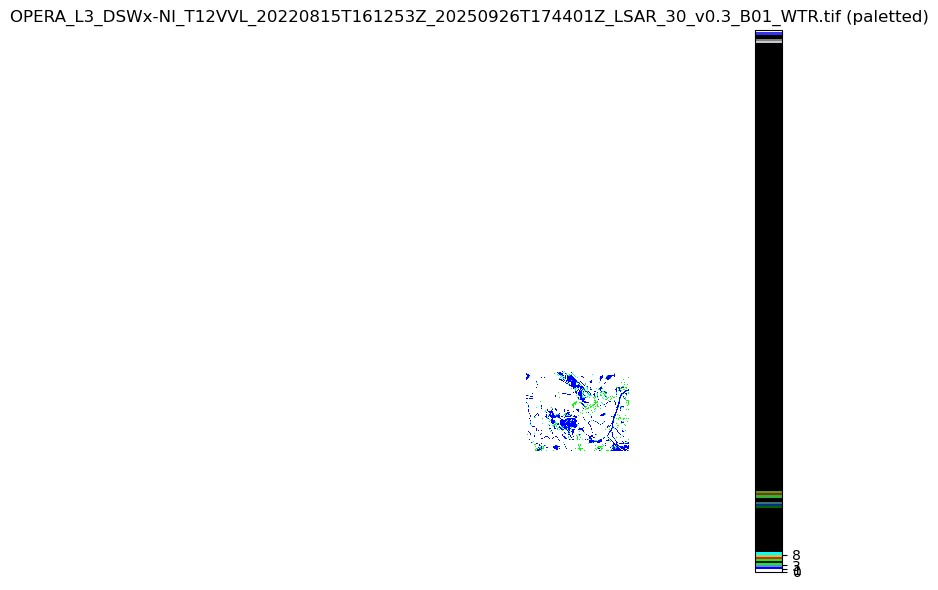

In [29]:
from notebook.util import plot_wtr
Product_ROOT = Path("./_cache/products").resolve()
tif_paths = sorted([p for p in Product_ROOT.rglob("*_WTR*.tif*") if p.is_file()])
for tif in tif_paths:
    plot_wtr(tif)

In scratch directory, the intermediate products can be found. 

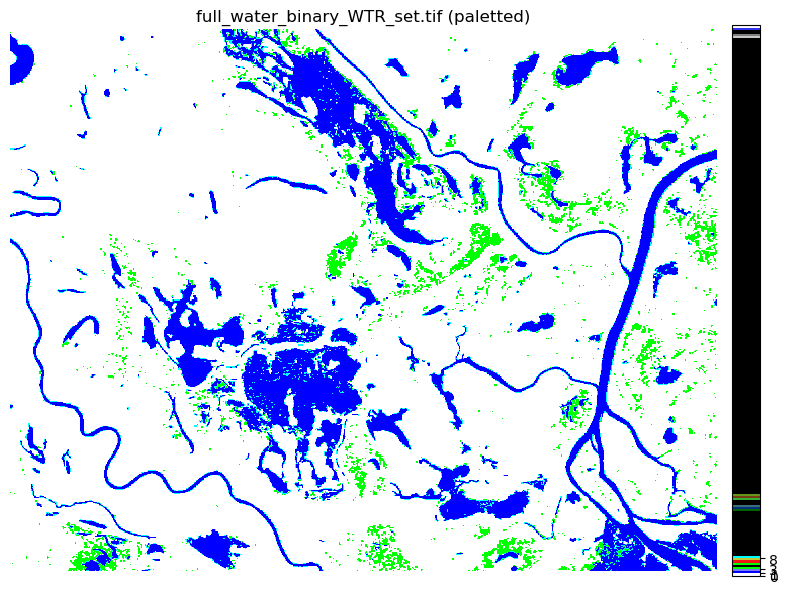

In [30]:
from notebook.util import plot_wtr

Product_ROOT = Path("./_cache/scratch").resolve()
tif_paths = sorted([p for p in Product_ROOT.rglob("*_WTR_set.tif*") if p.is_file()])

for tif in tif_paths:
    plot_wtr(tif)


- Blue : Open water
- Green: Inundated vegetation
- White : Non-water